### Input Data



- [Specification of flight data](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)
- [S3 Location for 2015 data](https://s3.amazonaws.com/agile_data_science/On_Time_On_Time_Performance_2015.csv.bz2)
- The fileds in CSV
```
  "Year","Quarter","Month",
     "DayofMonth","DayOfWeek","FlightDate","UniqueCarrier",
     "AirlineID","Carrier","TailNum","FlightNum",
    "OriginAirportID","OriginAirportSeqID","OriginCityMarketID",
    "Origin","OriginCityName","OriginState","OriginStateFips",
    "OriginStateName","OriginWac","DestAirportID","DestAirportSeqID",
    "DestCityMarketID","Dest","DestCityName","DestState",
    "DestStateFips","DestStateName","DestWac","CRSDepTime","DepTime",
    "DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups",
    "DepTimeBlk","TaxiOut","WheelsOff","WheelsOn","TaxiIn",
    "CRSArrTime","ArrTime","ArrDelay","ArrDelayMinutes",
    "ArrDel15","ArrivalDelayGroups","ArrTimeBlk","Cancelled",
    "CancellationCode","Diverted","CRSElapsedTime",
    "ActualElapsedTime","AirTime","Flights","Distance",
    "DistanceGroup","CarrierDelay","WeatherDelay","NASDelay","Security
    Delay","LateAircraftDelay","FirstDepTime","TotalAddGTime",
    "LongestAddGTime","DivAirportLandings","DivReachedDest",
    "DivActualElapsedTime","DivArrDelay","DivDistance","Div1Airport",
    "Div1AirportID","Div1AirportSeqID","Div1WheelsOn",
    "Div1TotalGTime","Div1LongestGTime","Div1WheelsOff",
    "Div1TailNum","Div2Airport","Div2AirportID",
    "Div2AirportSeqID","Div2WheelsOn","Div2TotalGTime",
    "Div2LongestGTime","Div2WheelsOff","Div2TailNum","Div3Airport",
    "Div3AirportID","Div3AirportSeqID","Div3WheelsOn",
    "Div3TotalGTime","Div3LongestGTime","Div3WheelsOff","Div3TailNum",
    "Div4Airport","Div4AirportID","Div4AirportSeqID",
    "Div4WheelsOn","Div4TotalGTime","Div4LongestGTime",
    "Div4WheelsOff","Div4TailNum","Div5Airport","Div5AirportID",
    "Div5AirportSeqID","Div5WheelsOn","Div5TotalGTime",
    "Div5LongestGTime","Div5WheelsOff","Div5TailNum"
```
- Data sample
```
2015,1,1,1,4,2015-01-01,"AA",19805,"AA","N787AA","1",12478,1247802,...,"JFK", ... 
2015,1,1,2,5,2015-01-02,"AA",19805,"AA","N795AA","1",12478,...,31703,"JFK", ... 
2015,1,1,3,6,2015-01-03,"AA",19805,"AA","N788AA","1",12478,...,31703,"JFK", ...
```



### Target
We want predict whether we will be delaied for our destination

We might formulate categories similar to the buckets we will use for the weather delay distribution (0–15, 15–60, and 60+), and then classify into these three categories.

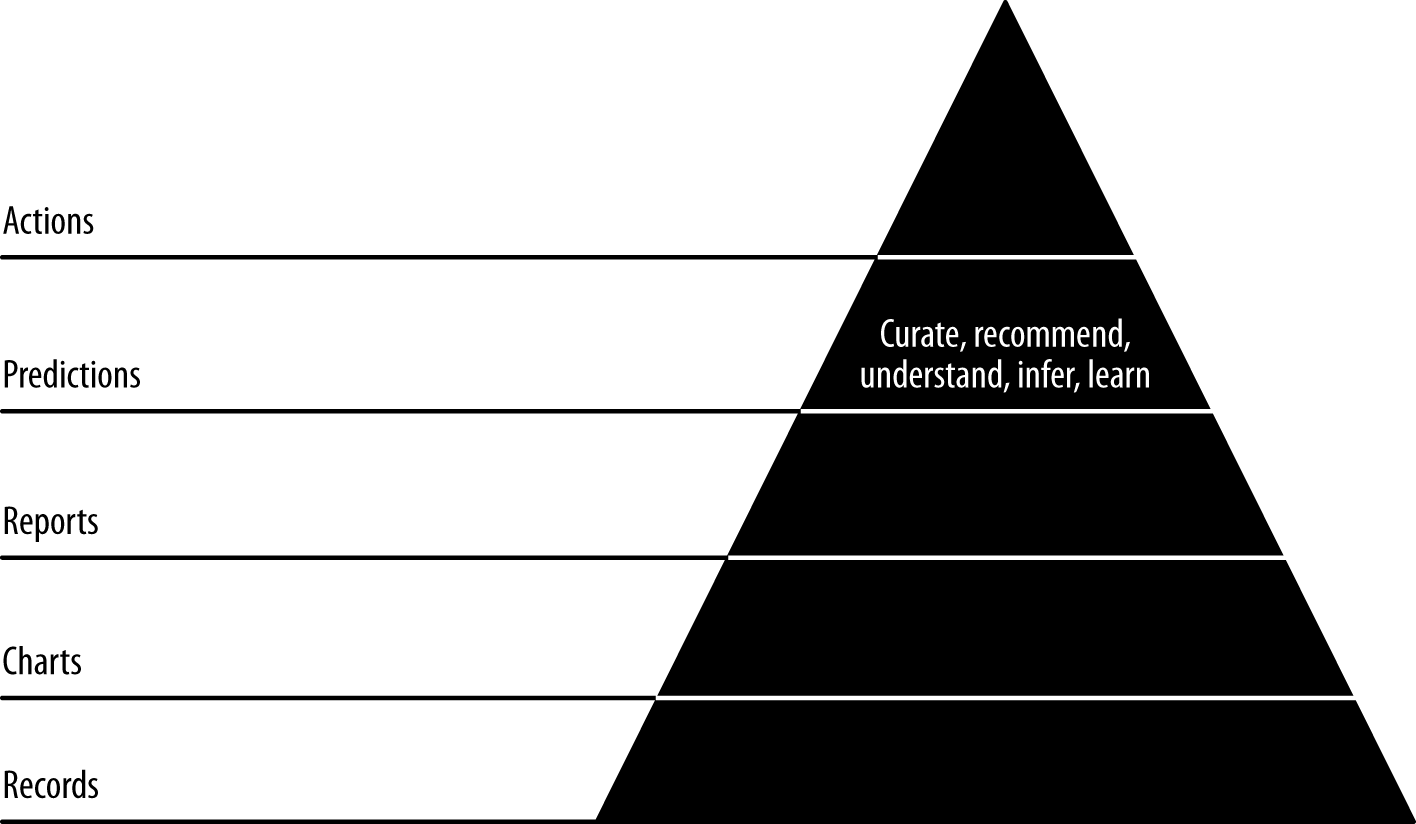

In [ ]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

## Loading data
1. `csv` files always be converted to row based compressed file format such as Parquet

2. Use spark `dataframe` not `rdd` to do operations, expecially for `python`
   



In [ ]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")


## Extracting Features with PySpark



In [ ]:

on_time_dataframe = on_time_dataframe.filter(on_time_dataframe.Month == '1')

# Select a few features of interest
simple_on_time_features = spark.sql("""
SELECT
  FlightNum,
  FlightDate,
  DayOfWeek,
  DayofMonth AS DayOfMonth,
  CONCAT(Month, '-',  DayofMonth) AS DayOfYear,
  Carrier,
  Origin,
  Dest,
  Distance,
  DepDelay,
  ArrDelay,
  CRSDepTime,
  CRSArrTime
FROM on_time_performance
  WHERE FlightDate < '2015-02-01'
""")
simple_on_time_features.show(5)

# Sample 10% to make executable inside the notebook
simple_on_time_features = simple_on_time_features.sample(False, 0.1)

```
+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|FlightNum|FlightDate|DayOfWeek|DayOfMonth|DayOfYear|Carrier|Origin|Dest|Distance|DepDelay|ArrDelay|CRSDepTime|CRSArrTime|
+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|     1519|2015-01-01|        4|         1|      1-1|     AA|   DFW| MEM|   432.0|    -3.0|    -6.0|      1345|      1510|
|     1519|2015-01-01|        4|         1|      1-1|     AA|   MEM| DFW|   432.0|    -4.0|    -9.0|      1550|      1730|
|     2349|2015-01-01|        4|         1|      1-1|     AA|   ORD| DFW|   802.0|     0.0|    26.0|      1845|      2115|
|     1298|2015-01-01|        4|         1|      1-1|     AA|   DFW| ATL|   731.0|   100.0|   112.0|      1820|      2120|
|     1422|2015-01-01|        4|         1|      1-1|     AA|   DFW| HDN|   769.0|    78.0|    78.0|      0800|      0925|
+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
```


Looks like a few flights don’t have delay information. Let’s filter those, and sort the data before saving it as a single JSON file:

In [ ]:
# Filter nulls, they can't help us
filled_on_time_features = simple_on_time_features.filter(
  simple_on_time_features.ArrDelay.isNotNull()
  &
  simple_on_time_features.DepDelay.isNotNull()
)

### DateTime Conversion

Now we need to convert all our dates and times (datetimes) from a string representation to a mathematical one—otherwise, our predictive algorithms can’t understand them in their proper and most useful contexts. To do so, we need some utility functions:

In [ ]:
# We need to turn timestamps into timestamps, and not strings or numbers
def convert_hours(hours_minutes):
  hours = hours_minutes[:-2]
  minutes = hours_minutes[-2:]
  
  if hours == '24':
    hours = '23'
    minutes = '59'
  
  time_string = "{}:{}:00Z".format(hours, minutes)
  return time_string

In [ ]:
def compose_datetime(iso_date, time_string):
  return "{} {}".format(iso_date, time_string)

In [ ]:
def create_iso_string(iso_date, hours_minutes):
  time_string = convert_hours(hours_minutes)
  full_datetime = compose_datetime(iso_date, time_string)
  return full_datetime

In [ ]:
def create_datetime(iso_string):
  return iso8601.parse_date(iso_string)

In [ ]:
def convert_datetime(iso_date, hours_minutes):
  iso_string = create_iso_string(iso_date, hours_minutes)
  dt = create_datetime(iso_string)
  return dt

In [ ]:
def day_of_year(iso_date_string):
  dt = iso8601.parse_date(iso_date_string)
  doy = dt.timetuple().tm_yday
  return doy

In [ ]:
def alter_feature_datetimes(row):
  flight_date = iso8601.parse_date(row['FlightDate'])
  scheduled_dep_time = convert_datetime(row['FlightDate'], row['CRSDepTime'])
  scheduled_arr_time = convert_datetime(row['FlightDate'], row['CRSArrTime'])

  # Handle overnight flights
  if scheduled_arr_time < scheduled_dep_time:
    scheduled_arr_time += datetime.timedelta(days=1)

  doy = day_of_year(row['FlightDate'])
  
  return {
    'FlightNum': row['FlightNum'],
    'FlightDate': flight_date,
    'DayOfWeek': int(row['DayOfWeek']),
    'DayOfMonth': int(row['DayOfMonth']),
    'DayOfYear': doy,
    'Carrier': row['Carrier'],
    'Origin': row['Origin'],
    'Dest': row['Dest'],
    'Distance': row['Distance'],
    'DepDelay': row['DepDelay'],
    'ArrDelay': row['ArrDelay'],
    'CRSDepTime': scheduled_dep_time,
    'CRSArrTime': scheduled_arr_time,
  }

```

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+-------------------+---------+------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|         FlightDate|FlightNum|Origin|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+-------------------+---------+------+
|     1.0|2015-01-01 10:06:00|2015-01-01 07:20:00|     AA|         1|        4|        1|    -6.0| MIA|   921.0|2015-01-01 00:00:00|     1173|   IAD|
|    13.0|2015-01-01 16:50:00|2015-01-01 15:25:00|     AA|         1|        4|        1|     9.0| DFW|   731.0|2015-01-01 00:00:00|      194|   ATL|
|    58.0|2015-01-01 18:50:00|2015-01-01 17:40:00|     AA|         1|        4|        1|    60.0| ONT|  1188.0|2015-01-01 00:00:00|     1605|   DFW|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+-------------------+---------+------+
```
only showing top 5 rows


In [ ]:
from pyspark.sql import Row
timestamp_features = filled_on_time_features.rdd.map(alter_feature_datetimes)
timestamp_df = timestamp_features.map(lambda x: Row(**x)).toDF()
timestamp_df.show(3)

Always explicitly sort your data before vectorizing it. Don’t leave the sort up to the system. If you do so, a software version change or some other unknown cause might ultimately change the sort order of your training data as compared with your result data. This would be catastrophic and confusing and should be avoided at all costs. Explicitly sorting training data in a way that avoids arbitrary sorting is essential:

In [ ]:
# Explicitly sort the data and keep it sorted throughout. 
# Leave nothing to chance.
sorted_features = timestamp_df.sort(
  timestamp_df.DayOfYear,
  timestamp_df.Carrier,
  timestamp_df.Origin,
  timestamp_df.Dest,
  timestamp_df.FlightNum,
  timestamp_df.CRSDepTime,
  timestamp_df.CRSArrTime,
)

Let’s copy the file into a JSON Lines file and check it out:

In [ ]:
# Store as a single JSON file and bzip2 it
sorted_features.write.mode("overwrite").json("../data/simple_flight_delay_features.json")

Now take a look at the result:

14M	../data/simple_flight_delay_features.json

==> ../data/simple_flight_delay_features.json/part-00000-b22e4fa9-4bf4-4696-a8dd-01989f88482e-c000.json <==
{"ArrDelay":13.0,"CRSArrTime":"2015-01-01T16:50:00.000Z","CRSDepTime":"2015-01-01T15:25:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":9.0,"Dest":"DFW","Distance":731.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"194","Origin":"ATL"}
{"ArrDelay":25.0,"CRSArrTime":"2015-01-01T20:30:00.000Z","CRSDepTime":"2015-01-01T19:00:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":-2.0,"Dest":"DFW","Distance":731.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"232","Origin":"ATL"}
{"ArrDelay":16.0,"CRSArrTime":"2015-01-01T15:30:00.000Z","CRSDepTime":"2015-01-01T14:25:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":24.0,"Dest":"DFW","Distance":190.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"2297","Origin":"AUS"}
{"ArrDelay":-31.0,"CRSArrTime":"2015-01-01T13:30:00.000Z","CRSDepTime":"2015-01-01T10:55:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":-4.0,"Dest":"ORD","Distance":978.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"2279","Origin":"AUS"}
{"ArrDelay":-30.0,"CRSArrTime":"2015-01-01T20:20:00.000Z","CRSDepTime":"2015-01-01T17:45:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":-8.0,"Dest":"ORD","Distance":978.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"2408","Origin":"AUS"}


## Building a Classifier with Spark ML


Spark's goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:_

* ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering

* Featurization: feature extraction, transformation, dimensionality reduction, and selection

* Pipelines: tools for constructing, evaluating, and tuning ML Pipelines

* Persistence: saving and load algorithms, models, and Pipelines

* Utilities: linear algebra, statistics, data handling, etc.

MLlib uses Spark DataFrames as the foundation for tables and records. Although some RDD-based methods still remain, they are not under active development.


In [ ]:
#
# {
#   "ArrDelay":5.0,"CRSArrTime":"2015-12-31T03:20:00.000-08:00",
#   "CRSDepTime":"2015-12-31T03:05:00.000-08:00",
#   "Carrier":"WN","DayOfMonth":31,"DayOfWeek":4,
#   "DayOfYear":365,"DepDelay":14.0,"Dest":"SAN",
#   "Distance":368.0, "FlightDate":"2015-12-30T16:00:00.000-08:00",
#   "FlightNum":"6109","Origin":"TUS"
# }
#

from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, TimestampType 
from pyspark.sql.types import StructType, StructField

schema = StructType([
  StructField("ArrDelay", FloatType(), True),       # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True), # "CRSArrTime":"2015-12..."
  StructField("CRSDepTime", TimestampType(), True), # "CRSDepTime":"2015-12..."
  StructField("Carrier", StringType(), True),       # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True),   # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),    # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),    # "DayOfYear":365
  StructField("DepDelay", FloatType(), True),       # "DepDelay":14.0
  StructField("Dest", StringType(), True),          # "Dest":"SAN"
  StructField("Distance", FloatType(), True),       # "Distance":368.0
  StructField("FlightDate", DateType(), True),      # "FlightDate":"2015-12..."
  StructField("FlightNum", StringType(), True),     # "FlightNum":"6109"
  StructField("Origin", StringType(), True),        # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.json", 
  schema=schema
)
features.first()


### Addressing Nulls

Before we can use the tools that PySpark’s MLlib provides us, we must eliminate null values from fields in rows of our DataFrames. Otherwise our code will crash as we start to employ tools from `pyspark.ml.features`.

To detect null values in columns, we need only loop through our columns and inspect them with `pyspark.sql.Column.isNull`:

In [ ]:
null_counts = [(column, features.where(features[column].isNull()).count()) \
  for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

If null values are found, we need only employ `DataFrame.na.fill` to fill them. Supply `fillna` with a dict with the column name as the key and the column’s fill value as the value, and it will fill in the column name with that value:

In [ ]:
# filled_features = features.na.fill({'DepDelay': 0})

In our dataset, no nulls are found, but there usually are some, so take note of this step for the future. It will save you trouble as you start engineering and vectorizing your features.

### Replacing FlightNum with Route

At this point it occurs to us that `FlightNums` will change, but routes do not… so long as we define a route as a pair of cities. So, let’s add a column Route, which is defined as the concatenation of `Origin`, -, and `Dest`, such as `ATL-SFO`. This will very simply inform our model whether certain routes are frequently delayed, separately from whether certain airports tend to have delays for inbound or outbound flights.

To add Route, we need to use two utilities from the pyspark.sql.functions package. The concat function concatenates multiple strings together, and the lit function is needed to specify a literal string to concatenate:

In [ ]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat
features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

### RDD Alternative RouteNum

Note that if we wanted to, we could convert the record to an RDD, where we could run something like the following:

```python
def add_route(record):
  record = record.asDict()
  record['Route'] = record['Origin'] + "-" + record['Dest']
  return record

features_with_route_rdd = features.rdd.map(add_route)
```

The reason to use DataFrames is that they are much, much faster than RDDs, even if the API is slightly more complex.

### Bucketizing a Continuous Variable for Classification

Classification does not work to predict a continuous variable like flight delays (in minutes); classifications predict two or more categories. Therefore, in order to build a classifier for flight delays, we have to create categories our of delays in minutes.  How to select proper bucket?

#### Determining Arrival Delay Buckets

In the first run-through writing the book, we used the same buckets as Bay Area startup FlightCaster (founded in 2009 and acquired in 2011 by Next Jump): on time, slightly late, and very late. The values corresponding to these bins come from a natural split in how people think about time in terms of minutes, hours, and days. One hour is an intuitive value for the high end of slightly late. Over one hour would then be very late. “On time” would be within 15 minutes of the scheduled arrival time. If such natural bins weren’t available, you would want to closely analyze the distribution of your continuous variable to determine what buckets to use.

As it turned out, this analysis was necessary in our case too. When writing the book, while debugging an issue with our Spark ML classifier model, we did an analysis where we found that a different set of categories were needed. Check out the Jupyter notebook at ch09/Debugging Prediction Problems.ipynb for details. Note that GitHub supports the display of Jupyter notebooks, which makes them a really powerful way to share data analyses—just commit and push to a GitHub repository and you’ve got a shared report. When you are doing iterative visualization, notebooks are very handy.

#### Iterative Visualization with Histograms

To begin, check out the overall distribution of flight delays, which we compute by converting the features `DataFrame` to an `RDD` and then employing `RDD.histogram`. `RDD.histogram` returns two lists: a set of buckets, and the count for each bucket. We then use `matplotlib.pyplot` to create a histogram. Note that because our buckets are already counted, we can’t use `pyplot.hist`. Instead, we employ `pyplot.bar` to create a histogram from our precomputed buckets and their corresponding counts.

To gather our data, we select the `ArrDelay` column, convert the DataFrame to an `RDD`, and call `RDD.flatMap` to convert our records into an `RDD` containing a single list of floats:

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Look at overall histogram
data_tuple = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])
data_tuple

In [ ]:
arr_delay = features.select("ArrDelay")

sample = arr_delay.filter(arr_delay.ArrDelay < 120).sample(False, 0.10)
sample.toPandas().hist('ArrDelay', bins=16)

```
([-87.0, -60, -30, -15, 0, 15, 30, 60, 120],
 [5, 1031, 7441, 18039, 9589, 3712, 2951, 1958])
```

![image](https://user-images.githubusercontent.com/16873751/85077501-4ed49280-b177-11ea-8229-f6a7e229e1fd.png)

Next, we extract the heights of the bars and the bin definitions from the tuple returned by histogram:

In [ ]:
heights = np.array(data_tuple[1])

# The bins are 1 > length than the values
full_bins = data_tuple[0]
full_bins

```
[-87.0, -60, -30, -15, 0, 15, 30, 60, 120]
```
Since bars are drawn from the left, we remove the rightmost item in the bins list:

In [ ]:
# Bars are drawn from the left
mid_point_bins = full_bins[:-1]
mid_point_bins

```
[-87.0, -60, -30, -15, 0, 15, 30, 60]
```
Next, we use a list comprehension to determine the range between the values defining the buckets, which gives us the width of the bars. We’ve decided that the bars should be as wide as the data they measure:

In [ ]:
# The width of a bar should be the range it maps in the data
widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
widths

```
[27.0, 30, 15, 15, 15, 15, 30, 60]
```
Finally, we plot the bar chart, specifying our bar widths (they draw from the left) and coloring our bars blue:

In [ ]:
# And now the bars should plot nicely
bar = plt.bar(mid_point_bins, heights, width=widths, color='b')

![image](https://user-images.githubusercontent.com/16873751/85078936-72e5a300-b17a-11ea-9d5c-d2fa97a0a6fc.png)

We can summarize the previous operations in a function called create_hist, which we will reuse to draw other histograms like this one:

In [ ]:
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

To start, let’s visualize the first set of buckets we considered: –87 to 15, 15 to 60, and 60 to 200. Note that the first item in the bucket definition, –87, comes from the minimum delay in the dataset. We use 200 to keep from distorting the chart, although the maximum delay is actually 1,971 minutes:

In [ ]:
%matplotlib inline

buckets = [-87.0, 15, 60, 200]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

![image](https://user-images.githubusercontent.com/16873751/85078961-842eaf80-b17a-11ea-8590-345fc3c91daf.png)

Wow. This is a very distorted distribution. We have created an imbalanced class set from one that should ideally be balanced. This is a problem, because imbalanced classes can produce classifiers that only predict the most common value, and yet still seem fairly accurate. At best, this label set would have made things hard for our classifier when there is no benefit to doing so. We need to rethink our labels.

Let’s try something a little more granular and check the distribution using the set of buckets: [-87.0, -30, -15, 0, 15, 30, 120]:

In [ ]:
%matplotlib inline

buckets = [-87.0, -30, -15, 0, 15, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

![image](https://user-images.githubusercontent.com/16873751/85078984-8d1f8100-b17a-11ea-8750-b0bdc7d8326e.png)

Hmm... this looks better, but the leftmost and rightmost buckets look too small. Let’s combine the –87 to –30 and –30 to –15 buckets, and try again:

In [ ]:
%matplotlib inline

buckets = [-87.0, -15, 0, 15, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

![image](https://user-images.githubusercontent.com/16873751/85079027-ac1e1300-b17a-11ea-9f12-c3282e02af76.png)

This looks better! However, the 15–30 bucket seems too small. Let’s merge this bucket with the 0–15 bucket and try again:

In [ ]:
%matplotlib inline

buckets = [-87.0, -15, 0, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

![image](https://user-images.githubusercontent.com/16873751/85079035-b3452100-b17a-11ea-8a0f-1bcfee777c6f.png)

he buckets end up being “very early” (> 15 minutes early), “early” (0–15 minutes early), “late” (0–30 minutes late), and “very late” (30+ minutes late). These aren’t perfect in terms of usability, but I think they can work. Ideally the distribution in the buckets would be equal, but they are close enough.




### Bucketizing with `pyspark.ml.feature.Bucketizer`

Creating buckets for classification is simpler using Bucketizer. We simply define our splits in a list, instantiate our Bucketizer, and then apply a transformation on our features DataFrame. We’ll do this transformation for the ArrDelay field:

In [ ]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 15.0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(10)

```
+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|     9.0|           2.0|
|   -12.0|           1.0|
|   -17.0|           0.0|
|    -9.0|           1.0|
|   -27.0|           0.0|
|   -29.0|           0.0|
|     9.0|           2.0|
|    -9.0|           1.0|
|   -36.0|           0.0|
|    12.0|           2.0|
+--------+--------------+
```


## Feature Vectorization with `pyspark.ml.feature`

Spark MLlib has an extremely rich library of functions for various machine learning tasks, so it is helpful when using MLlib to have the API documentation open in a browser tab, along with the DataFrame API documentation. While an RDD-based API does exist, we’ll be using the DataFrame-based MLlib routines.

### Vectorizing Categorical Columns with Spark ML


To follow along with this section, open the pyspark.ml.feature documentation. First we need to import our tools from pyspark.ml.feature:
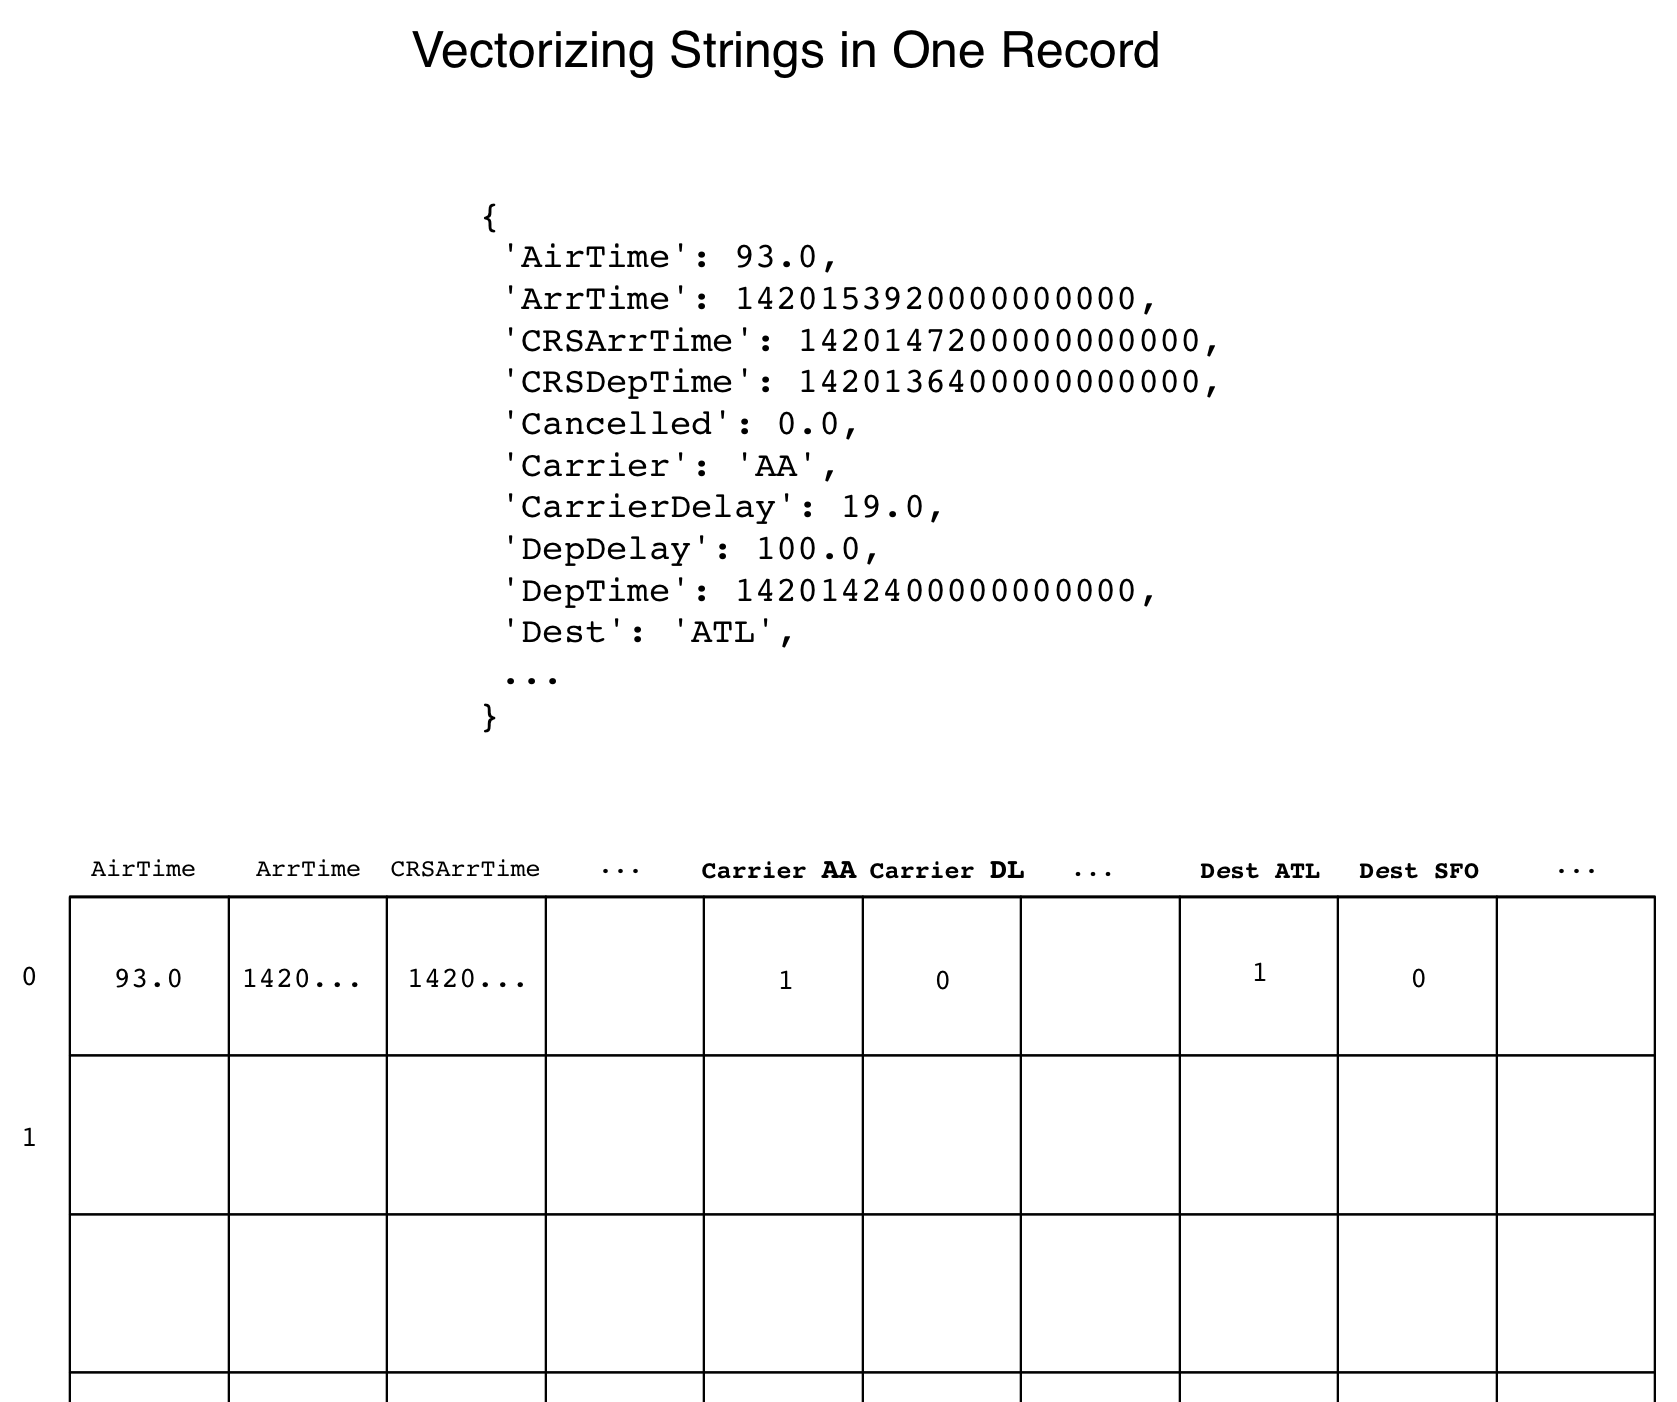

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

Then we need to index our nominal or categorical string columns into sets of vectors made up of binary variables for every unique value found in a given column. To achieve this, for each categorical column (be it a string or number), we need to:

1. Configure and create a StringIndexer to index the column into one number per unique value.

2. Execute fit on the StringIndexer to get a StringIndexerModel.

3. Run the training data through StringIndexerModel.transform to index the strings into a new column.

The code to implement these steps for each categorical variable column looks like this:

In [ ]:
# Turn category fields into categoric feature vectors, then drop 
# intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                         .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

```
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|     9.0|2015-01-29 10:59:00|2015-01-29 09:30:00|     UA|        29|        4|       29|     0.0| EWR|   200.0|2015-01-29|      657|   BOS|BOS-EWR|           2.0|          5.0|             5.0|            1.0|            5.0|        17.0|      17.0|      274.0|
|   -12.0|2015-01-29 08:37:00|2015-01-29 06:47:00|     UA|        29|        4|       29|     3.0| ORD|   867.0|2015-01-29|     1037|   BOS|BOS-ORD|           1.0|          5.0|             5.0|            1.0|            5.0|        17.0|       2.0|       94.0|
|   -17.0|2015-01-29 19:19:00|2015-01-29 17:26:00|     UA|        29|        4|       29|     1.0| ORD|   867.0|2015-01-29|     1118|   BOS|BOS-ORD|           0.0|          5.0|             5.0|            1.0|            5.0|        17.0|       2.0|       94.0|
|    -9.0|2015-01-29 09:45:00|2015-01-29 06:00:00|     UA|        29|        4|       29|    -6.0| SFO|  2704.0|2015-01-29|      433|   BOS|BOS-SFO|           1.0|          5.0|             5.0|            1.0|            5.0|        17.0|       6.0|      501.0|
|   -27.0|2015-01-29 18:15:00|2015-01-29 16:42:00|     UA|        29|        4|       29|    -2.0| DEN|  1201.0|2015-01-29|      467|   CLE|CLE-DEN|           0.0|          5.0|             5.0|            1.0|            5.0|        41.0|       3.0|      569.0|
|   -29.0|2015-01-29 10:59:00|2015-01-29 07:55:00|     UA|        29|        4|       29|     0.0| FLL|  1062.0|2015-01-29|     1026|   CLE|CLE-FLL|           0.0|          5.0|             5.0|            1.0|            5.0|        41.0|      19.0|     1528.0|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
```

Having indexed our categorical features, now we combine them with our numeric features into a single feature vector for our classifier.

### Vectorizing Continuous Variables and Indexes with Spark ML

As they are already numeric, there isn’t much work required to vectorize our continuous numeric features. And now that we have indexes, we have a numeric representation of each string column. Now we simply employ VectorAssembler to combine the numeric and index columns into a single feature Vector. Then we drop the index columns, as they aren’t needed anymore:

In [ ]:
# Handle continuous numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show(10)

final_vectorized_features = final_vectorized_features.filter(final_vectorized_features.FlightDate < '2015-02-01')

```
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|     9.0|2015-01-29 10:59:00|2015-01-29 09:30:00|     UA|        29|        4|       29|     0.0| EWR|   200.0|2015-01-29|      657|   BOS|BOS-EWR|           2.0|[0.0,200.0,5.0,5....|
|   -12.0|2015-01-29 08:37:00|2015-01-29 06:47:00|     UA|        29|        4|       29|     3.0| ORD|   867.0|2015-01-29|     1037|   BOS|BOS-ORD|           1.0|[3.0,867.0,5.0,5....|
|   -17.0|2015-01-29 19:19:00|2015-01-29 17:26:00|     UA|        29|        4|       29|     1.0| ORD|   867.0|2015-01-29|     1118|   BOS|BOS-ORD|           0.0|[1.0,867.0,5.0,5....|
|    -9.0|2015-01-29 09:45:00|2015-01-29 06:00:00|     UA|        29|        4|       29|    -6.0| SFO|  2704.0|2015-01-29|      433|   BOS|BOS-SFO|           1.0|[-6.0,2704.0,5.0,...|
|   -27.0|2015-01-29 18:15:00|2015-01-29 16:42:00|     UA|        29|        4|       29|    -2.0| DEN|  1201.0|2015-01-29|      467|   CLE|CLE-DEN|           0.0|[-2.0,1201.0,5.0,...|
|   -29.0|2015-01-29 10:59:00|2015-01-29 07:55:00|     UA|        29|        4|       29|     0.0| FLL|  1062.0|2015-01-29|     1026|   CLE|CLE-FLL|           0.0|[0.0,1062.0,5.0,5...|
|     9.0|2015-01-29 08:16:00|2015-01-29 07:45:00|     UA|        29|        4|       29|    -4.0| ORD|   315.0|2015-01-29|     1715|   CLE|CLE-ORD|           2.0|[-4.0,315.0,5.0,5...|
|    -9.0|2015-01-29 18:08:00|2015-01-29 16:56:00|     UA|        29|        4|       29|    -6.0| ORD|   599.0|2015-01-29|      411|   CLT|CLT-ORD|           1.0|[-6.0,599.0,5.0,5...|
|   -36.0|2015-01-29 09:41:00|2015-01-29 07:00:00|     UA|        29|        4|       29|    -6.0| IAH|  1208.0|2015-01-29|     1657|   DCA|DCA-IAH|           0.0|[-6.0,1208.0,5.0,...|
|    12.0|2015-01-29 12:39:00|2015-01-29 11:05:00|     UA|        29|        4|       29|    19.0| BIL|   455.0|2015-01-29|     1293|   DEN|DEN-BIL|           2.0|[19.0,455.0,5.0,5...|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
```


Now we’re ready to train our classifier!

### Classification with Spark ML

Our features are prepared in a single field, Features_vec, and we’re ready to compose the experiment we’ll run as part of creating our classifier. To drive our experiment, we require a training dataset and a test dataset. As we discussed earlier, a training dataset is used to train the model and a test set is used to gauge its accuracy. Cross-validation ensures that the models we create in the lab perform well in the real world, and not just on paper.

#### Test/Train Split with DataFrames

As before with scikit-learn, we need to cross-validate. This means splitting our data between a training set and a test set.

The DataFrame API makes this easy with `DataFrame.randomSplit`. This takes an array featuring the ratios of the splits, which should add up to 1:

In [ ]:
# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.8, 0.2], seed=27)

### Creating and Fitting a Model

It takes three lines to import, instantiate, and fit a random forest classifier using our training dataset. Note that we’re using a random forest classifier because this is the most accurate decision tree model available in Spark MLlib that can classify into multiple categories. These classifiers also offer feature importances, which we will use in Chapter 9 to improve the model.

Also note that we run the model once, and it throws an exception because we have more than 32 unique values for one feature, the default value for maxBins. We set maxBins to the value suggested by the exception, 4657, and the model fits successfully. Note that this can take a while, so grab some coffee:

In [ ]:
# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024,
  seed=27
)
model = rfc.fit(training_data)

In [ ]:
model

Next, we need to evaluate the classifier we’ve created.

### EVALUATING A MODEL

We can evaluate the performance of our classifier using the `MulticlassClassificationEvaluator`, which simply wraps the predictions we get from running `pyspark.ml.classification.RandomForestClassificationModel.transform` on the test dataset. Several metrics are available, but we’ll start with the raw accuracy:

In [ ]:
# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
  labelCol="ArrDelayBucket", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

Not great, but good enough for now. Don’t worry, we’ll work on making the model more accurate in Chapter 9.

Let’s lay eyes on some of the predictions, to see that they’re sane. At one point we had a bug where all predictions were 0.0. Seeing a sample with different prediction values takes a bit of cleverness because of the way the transformation sorts the data, so we order the sample by the reservation system departure time before displaying it:

In [ ]:
# Sanity-check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

```
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|     9.0|2015-01-01 13:09:00|2015-01-01 11:20:00|     US|         1|        4|        1|    14.0| PBI|   590.0|2015-01-01|     1983|   CLT|CLT-PBI|           2.0|[14.0,590.0,6.0,2...|[1.51427525613448...|[0.07571376280672...|       2.0|
|    17.0|2015-01-02 14:59:00|2015-01-02 10:15:00|     EV|         2|        5|        2|     2.0| CMH|  1154.0|2015-01-02|     4251|   DEN|DEN-CMH|           3.0|[2.0,1154.0,2.0,1...|[4.07963344542491...|[0.20398167227124...|       1.0|
|   -21.0|2015-01-04 17:01:00|2015-01-04 15:36:00|     B6|         4|        7|        4|    -8.0| BOS|   399.0|2015-01-04|      690|   DCA|DCA-BOS|           0.0|[-8.0,399.0,8.0,1...|[4.379892488116,9...|[0.2189946244058,...|       1.0|
|   205.0|2015-01-08 14:55:00|2015-01-08 08:45:00|     UA|         8|        4|        8|   102.0| ORD|  1744.0|2015-01-08|     1084|   LAX|LAX-ORD|           4.0|[102.0,1744.0,5.0...|[0.30996222720933...|[0.01549811136046...|       4.0|
|   -18.0|2015-01-08 20:02:00|2015-01-08 18:20:00|     DL|         8|        4|        8|    -2.0| DCA|   547.0|2015-01-08|     1738|   ATL|ATL-DCA|           0.0|[-2.0,547.0,1.0,1...|[3.87135350468531...|[0.19356767523426...|       1.0|
|    -4.0|2015-01-16 20:39:00|2015-01-16 19:00:00|     EV|        16|        5|       16|    -4.0| EWR|   445.0|2015-01-16|     4368|   GSO|GSO-EWR|           1.0|[-4.0,445.0,2.0,0...|[4.95868706175130...|[0.24793435308756...|       1.0|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
```

Now let’s see the distribution of the Prediction field, to verify we don’t have that same bug:

In [ ]:
predictions.groupBy("Prediction").count().orderBy('Prediction').show()

```
+----------+-----+
|Prediction|count|
+----------+-----+
|       0.0|   45|
|       1.0| 6473|
|       2.0| 1287|
|       3.0|  167|
|       4.0| 1191|
+----------+-----+
```

This “sanity check” seems okay!

### Evaluation Conclusion

With Spark, we can create, train, and evaluate a classifier or regression in a few lines of code. Surprisingly, it is even more powerful than scikit-learn. But to be useful, we’ve got to deploy our prediction. We’ll do that in the next chapter.

Now we have a problem—how do we deploy Spark ML models? Unlike scikit-learn models, we can’t simply place them inside our web application as an API, because they require the Spark platform to run. This is something we will address in the next chapter.



## Conclusion

In this chapter we’ve taken what we know about the past to predict the future.

In the next chapter, we’ll drill down into this prediction to drive a new action that can take advantage of it.

In [ ]:
predictions.select("ArrDelayBucket","prediction").show(5)

```

+--------------+----------+
|ArrDelayBucket|prediction|
+--------------+----------+
|           0.0|       1.0|
|           0.0|       1.0|
|           0.0|       1.0|
|           0.0|       1.0|
|           0.0|       1.0|
+--------------+----------+
```